In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

In [2]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
df = pd.read_csv("anxiety_pre_features_tfidf_256.csv", on_bad_lines='skip')
print(len(df['author'].unique()))
df

19976


,subreddit,author,date,post,automated_readability_index,coleman_liau_index,flesch_kincaid_grade_level,flesch_reading_ease,gulpease_index,gunning_fog_index,...,tfidf_wish,tfidf_without,tfidf_wonder,tfidf_work,tfidf_worri,tfidf_wors,tfidf_would,tfidf_wrong,tfidf_x200b,tfidf_year
0,anxiety,ljf3030,2019/07/06,"I can always feel my heartbeat 18M, physically...",2.170434,4.487956,3.548088,87.287230,79.672269,5.983473,...,0.0,0.0,0.189895,0.000000,0.177828,0.000000,0.000000,0.000000,0.0,0.0
1,anxiety,1millionkarmagoal,2019/07/06,My dad is hospitalized and had to be put in a ...,3.134304,4.708127,4.747114,83.239617,74.141509,8.573141,...,0.0,0.0,0.000000,0.100424,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,anxiety,ItsIncremento,2019/07/06,Feels like anxiety is turning my brain to stew...,6.312041,6.382021,7.461489,72.180233,65.800000,10.365909,...,0.0,0.0,0.000000,0.000000,0.177881,0.000000,0.000000,0.095754,0.0,0.0
3,anxiety,Emet_Throwaway,2019/07/06,What do you do when anxiety kicks in around ot...,6.440313,7.155612,6.506250,76.913750,65.562500,10.150000,...,0.0,0.0,0.000000,0.000000,0.000000,0.509329,0.000000,0.000000,0.0,0.0
4,anxiety,throwaway239423489,2019/07/06,Finding a job is a nightmare I want to rant ab...,5.645490,7.352487,6.719651,71.042334,68.032258,10.033295,...,0.0,0.0,0.000000,0.081788,0.000000,0.114489,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19971,anxiety,heretothrowawaynow,2019/08/11,Ugh I didn't check my class GC for 3 days beca...,0.793333,1.986409,2.856667,95.955000,79.555556,5.911111,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
19972,anxiety,throwawayreddit67778,2019/08/11,Anybody else get bad anxiety the day after eat...,4.184799,5.402657,5.798976,78.125492,70.987952,9.388755,...,0.0,0.0,0.125248,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
19973,anxiety,throwaway52689533564,2019/08/11,My brain is cruel Looking for some advice. I'...,1.801679,4.017217,3.496186,87.716433,80.391753,6.453714,...,0.0,0.0,0.000000,0.270118,0.000000,0.000000,0.131786,0.101417,0.0,0.0
19974,anxiety,krisappear,2019/08/11,I change how I live to avoid potentially upset...,5.703326,7.040841,5.407554,81.896549,67.521739,8.184783,...,0.0,0.0,0.000000,0.000000,0.178041,0.000000,0.249078,0.000000,0.0,0.0


In [4]:
def run(num):
  return 1;

In [5]:
df = df[["subreddit", 'post']]
df['subreddit'] = df['subreddit'].apply(run)
df

,subreddit,post
0,1,"I can always feel my heartbeat 18M, physically..."
1,1,My dad is hospitalized and had to be put in a ...
2,1,Feels like anxiety is turning my brain to stew...
3,1,What do you do when anxiety kicks in around ot...
4,1,Finding a job is a nightmare I want to rant ab...
...,...,...
19971,1,Ugh I didn't check my class GC for 3 days beca...
19972,1,Anybody else get bad anxiety the day after eat...
19973,1,My brain is cruel Looking for some advice. I'...
19974,1,I change how I live to avoid potentially upset...


In [6]:
ds = pd.read_parquet("hf://datasets/google-research-datasets/go_emotions/raw/train-00000-of-00001.parquet", engine = 'fastparquet')

In [7]:
ds = ds[['text']]

In [8]:
ds['post'] = ds['text'][0:len(df)]
ds = ds.drop('text', axis = 1)
ds = ds[:len(df)]
ds['subreddit']=0
df = pd.concat([df, ds])
df.reset_index()
df.dropna(inplace = True)

In [9]:
df

,subreddit,post
0,1,"I can always feel my heartbeat 18M, physically..."
1,1,My dad is hospitalized and had to be put in a ...
2,1,Feels like anxiety is turning my brain to stew...
3,1,What do you do when anxiety kicks in around ot...
4,1,Finding a job is a nightmare I want to rant ab...
...,...,...
19971,0,Don't care. Have fun. Got better things to do.
19972,0,Great idea! Thanks :)
19973,0,Good luck to [NAME] if he really thinks he can...
19974,0,The scorpion one on the swing set looked so ba...


In [10]:
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, force_download=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [11]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [12]:
# Store length of each review
token_lens = []

# Iterate through the content slide
for txt in df.post:
    tokens = tokenizer.encode(txt, max_length=5000)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

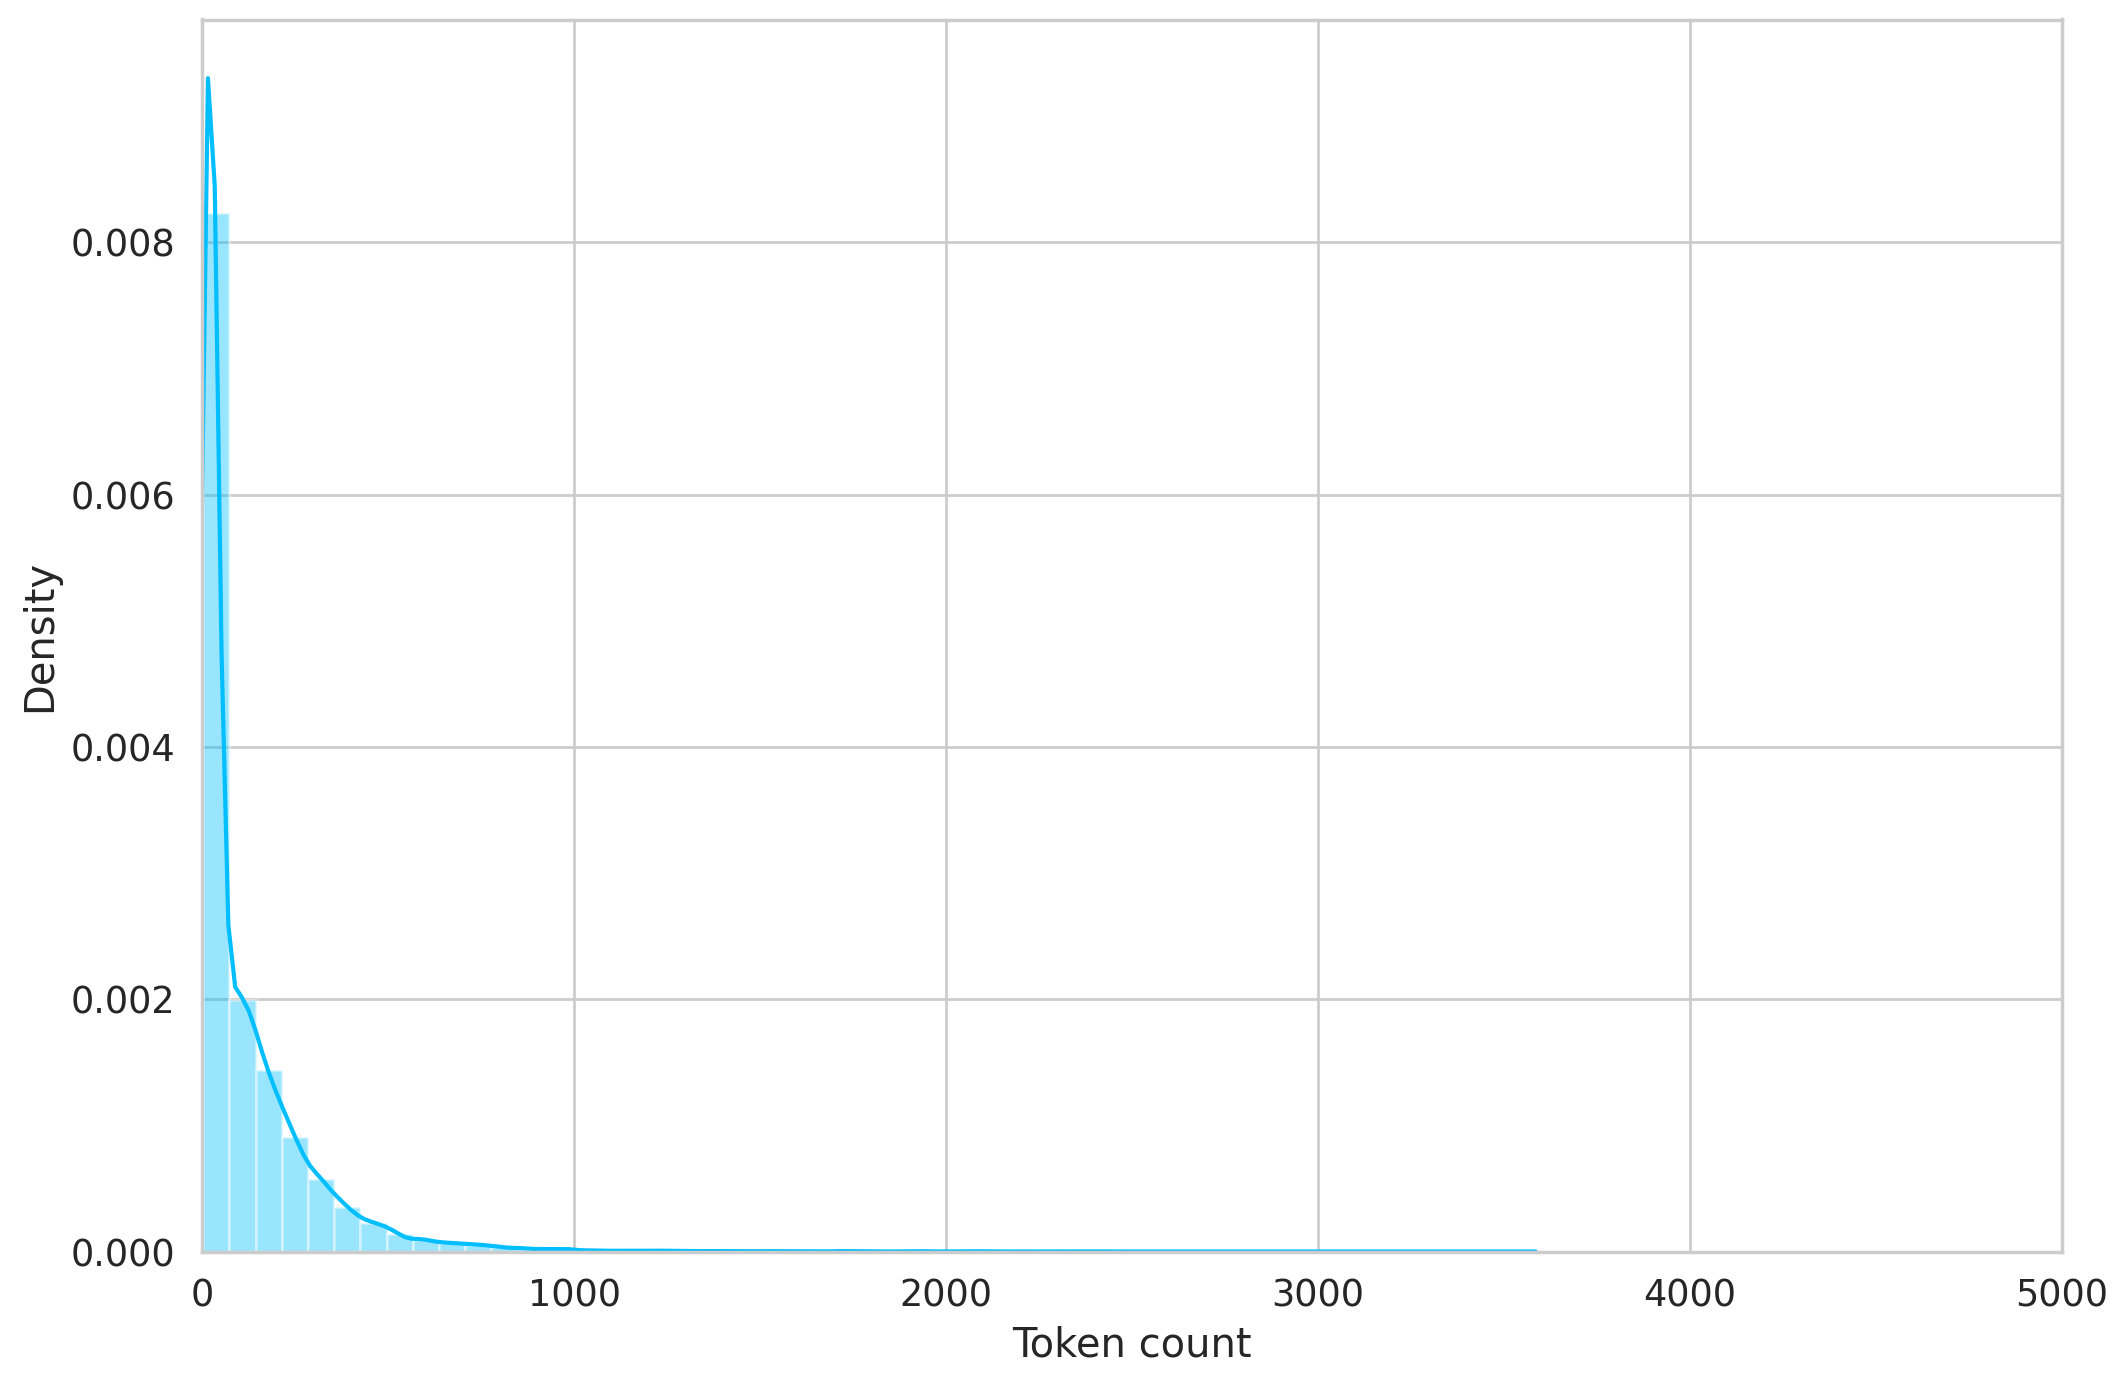

In [13]:
# plot the distribution of review lengths
sns.distplot(token_lens)
plt.xlim([0, 5000]);
plt.xlabel('Token count')

In [14]:

MAX_LEN = 512

In [15]:
from torch.utils.data import Dataset, DataLoader
import torch
class TweetDataset(Dataset):
    # Constructor Function
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    # Length magic method
    def __len__(self):
        return len(self.reviews)

    # get item magic method
    def __getitem__(self, item):
        review = self.reviews[item]
        target = self.targets[item]

        # Encoded format to be returned
        encoding = [
            self.tokenizer.encode_plus(
                x,
                add_special_tokens=True,
                max_length=self.max_len,
                return_token_type_ids=False,
                padding = 'max_length',
                truncation = True,
                return_tensors='pt',
            ) for x in review
        ]

        return {
            'review_text': review,
            'input_ids': [x['input_ids'].flatten() for x in encoding],
            'attention_mask': [x['attention_mask'].flatten() for x in encoding],
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [16]:
class TweetDataset(Dataset):
    # Constructor Function
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    # Length magic method
    def __len__(self):
        return len(self.reviews)

    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        # Encoded format to be returned


        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [17]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(31961, 2) (3995, 2) (3996, 2)


In [18]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = TweetDataset(
        reviews=df.post.to_numpy(),
        targets=df.subreddit.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [19]:

# Create train, test and val data loaders
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [20]:
# Examples
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16])


In [21]:
bert_model = BertModel.from_pretrained(MODEL_NAME)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [22]:
# Build the Sentiment Classifier class
class SentimentClassifier(nn.Module):

    # Constructor class
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, 1)

    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        #  Add a dropout layer
        output = self.drop(pooled_output)
        return torch.sigmoid(self.out(output))

In [23]:
class_names = ['not anxious','anxious']
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [24]:
# Number of hidden units
print(bert_model.config.hidden_size)

768


In [25]:
#Number of iterations
EPOCHS = 4

# Optimizer Adam
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function
loss_fn = nn.BCELoss().to(device)

In [26]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples, progress_bar=None):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        outputs = torch.reshape(outputs, (-1, 1)).float()
        targets = torch.reshape(targets, (-1, 1)).float()

        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(outputs == targets)
        losses.append(loss.item())

        # Backward prop
        loss.backward()

        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        if progress_bar:
            progress_bar.update(1)

    return correct_predictions.double() / n_examples, np.mean(losses)

In [27]:
def eval_model(model, data_loader, loss_fn, device, n_examples, progress_bar=None):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            outputs = torch.round(torch.reshape(outputs, (-1, 1)).float())
            targets = torch.reshape(targets, (-1, 1)).float()

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(outputs == targets)
            losses.append(loss.item())

            if progress_bar:
                progress_bar.update(1)

    return correct_predictions.double() / n_examples, np.mean(losses)

In [28]:
%%time

history = defaultdict(list)
best_accuracy = 0


for epoch in range(EPOCHS):

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    # Initialize the progress bar for training
    train_progress_bar = tqdm(total=len(train_data_loader), desc="Training", position=0, leave=True)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train),
        train_progress_bar  # Pass the progress bar to your train_epoch function
    )

    print(f"Train loss {train_loss} accuracy {train_acc}")

    # Initialize the progress bar for validation
    val_progress_bar = tqdm(total=len(val_data_loader), desc="Validation", position=0, leave=True)

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val),
        val_progress_bar  # Pass the progress bar to your eval_model function
    )

    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/4
----------


Training:   0%|▏                                                                    | 6/1998 [01:56<12:18:48, 22.25s/it]

KeyboardInterrupt: 